## Objetivo

Entrenar un modelo de red neuronal artificial profunda para resolver una tarea de clasificación multiclase usando PyTorch.


## Descripción de la tarea

Vamos a usar el conjunto de datos [cardiovascular_disease.csv](https://www.kaggle.com/datasets/bhadaneeraj/cardio-vascular-disease-detection?select=cardio_train.csv).

El modelo debe clasificar si los pacientes tienen o no, enfermedad cardiovascular.


# Neuronal network

### Imports

In [14]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

### Creación de conjuntos de datos

> Entrenamiento
> 
> Prueba

In [15]:
df_data = pd.read_csv('./../data/filtered_cardiovascular_disease.csv', index_col= 0) # Dataset viejo
# df_data = pd.read_csv('./../data/.csv', index_col= 0) # Dataset nuevo
df_data['cardio'] = df_data['cardio'].replace({0: 'No Disease', 1: 'Disease'})
scaler = StandardScaler()
df_data[['age_days', 'age_year', 'height', 'weight', 'bmi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_group', 'pulse', 'pulse_group', 'aphi_group', 'ap_hi', 'ap_lo']] = scaler.fit_transform(df_data[['age_days', 'age_year', 'height', 'weight', 'bmi', 'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'age_group', 'pulse', 'pulse_group', 'aphi_group', 'ap_hi', 'ap_lo']]) # Estandarizar/Normalizar
# df_data = df_data.drop(columns=['age_days']) # Todas las columnas a quitar
print(df_data.shape)
print(df_data.cardio.unique())
train_df, test_df = train_test_split(df_data, test_size=0.2, random_state= 42)
print(train_df.shape)
print(test_df.shape)

(65390, 18)
['No Disease' 'Disease']
(52312, 18)
(13078, 18)


### Objeto CardioDataset

Sobre escribe algunos métodos del objeto Dataset de <torch.utils.data>

In [16]:
labels_to_ids = {
    'No Disease' : 0,
    'Disease' : 1
}

ids_to_labels = {v: k for v, k in enumerate(labels_to_ids)}

class CardioDataset(Dataset):
    """NER dataset."""
    def __init__(self, dataframe):
        """
        Args:
            data : Pandas dataframe.
        """
        self.len = len(dataframe)
        self.data = dataframe
 
    def __getitem__(self, index):
        
        # # step 1: get data and label
        features = self.data.drop(['cardio'], axis=1).iloc[index]
        cardio_labels = self.data.cardio.iloc[index]
        # print(cardio_labels)

        # step 2: encode labels
        encoded_labels = labels_to_ids[cardio_labels]

        # step 3: turn everything into PyTorch tensors
        pacient_features = torch.as_tensor(features)
        label = torch.as_tensor(encoded_labels)
        return pacient_features, label

    def __len__(self):
        return self.len

train_dataset = CardioDataset(dataframe=train_df)
test_dataset = CardioDataset(dataframe=test_df)

### Creación de `DataLoader`

Definimos un tamaño de lote para que la red ajuste sus pesos cada 128 ejemplos (`batch_size = 128`).

Creamos dos objetos `DataLoader` para iterar ambos conjuntos de datos por lotes.


In [17]:
batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle= True)

for X, y in train_dataloader:
    print(f"Dimensionalidad de datos X: {X.shape}")
    print(f"Dimensionalidad de categorías y: {y.shape}, tipo de categorías: {y.dtype}")
    break

Dimensionalidad de datos X: torch.Size([128, 17])
Dimensionalidad de categorías y: torch.Size([128]), tipo de categorías: torch.int64


### Definición de `device` para entrenamiento

In [18]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Device a utilizar: {device}")


Device a utilizar: cpu


### Definición de arquitectura de la red neuronal

Creamos la clase `RedNeuronal` a partir de la clase base [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). Esta clase será definida de acuerdo a la arquitectura de red que deseamos entrenar.

Debemos definir:
- Capas
- Nodos por capa
- Función de activación
- Procesamiento hacia adelante de la red (`forward`)

Al final indicamos que la red debe crearse en el `device` definido anteriormente.


In [20]:
# Define modelo
class RedNeuronal(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(17, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.double()
    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = RedNeuronal().to(device)
print(model)

RedNeuronal(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=17, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=256, bias=True)
    (9): ReLU()
    (10): Linear(in_features=256, out_features=128, bias=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=1, bias=True)
    (13): Sigmoid()
  )
)


### Definición de función de pérdida y optimizador

In [39]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

### Definición de método de entrenamiento (`train`)

Esto incluye procesar los datos del `dataloader` lote por lote "hacia delante" y calcular el error de predicción de la red, esto es, el valor de la función de pérdida. Luego debemos propagar el error de predicción "hacia atrás" de la red para ajustar los pesos de los nodos. En cada iteración, la red ajustará los pesos para predecir cada vez mejor.


In [40]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y.double().view(-1, 1))

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 10 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"Valor de función de pérdida: {loss:>7f}  [{current:>5d}/{size:>5d}]")

### Definición de método de prueba (`test`)

Esto incluye procesar los datos de prueba lote por lote, esto es, hacer que la red previamente entrenada realice predicciones sobre estos datos y acumular tanto el error (valor de la función de perdida) como los aciertos de la red (valor de exactitud o `Accuracy`).


In [37]:
def test(dataloader, model, loss_fn, threshold):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y.double().view(-1, 1)).item()
            predictions = (pred > threshold).float()
            correct += (predictions.view(-1) == y.float()).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Fase de prueba: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}, Probability Threshold: {threshold} \n")

----------------------------------------------------------
## Entrenamiento de la red neuronal

Ejecutamos los métodos de entrenamiento (`train`) y prueba (`test`) por un número de épocas (veces que la red entrena usando todos los datos disponibles).

El `train` imprimirá el valor de pérdida por cada 10 lotes. El método `test` imprimirá el valor de pérdida y la exactitud de predicción.


In [14]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn, 0.5)
    test(test_dataloader, model, loss_fn, 0.6)
    test(test_dataloader, model, loss_fn, 0.7)
    test(test_dataloader, model, loss_fn, 0.8)
print("Done!")

Epoch 1
-------------------------------
Valor de función de pérdida: 0.644960  [   64/52312]
Valor de función de pérdida: 0.637332  [  704/52312]
Valor de función de pérdida: 0.664951  [ 1344/52312]
Valor de función de pérdida: 0.647771  [ 1984/52312]
Valor de función de pérdida: 0.645988  [ 2624/52312]
Valor de función de pérdida: 0.617003  [ 3264/52312]
Valor de función de pérdida: 0.621234  [ 3904/52312]
Valor de función de pérdida: 0.722292  [ 4544/52312]
Valor de función de pérdida: 0.642768  [ 5184/52312]
Valor de función de pérdida: 0.637257  [ 5824/52312]
Valor de función de pérdida: 0.624610  [ 6464/52312]
Valor de función de pérdida: 0.679570  [ 7104/52312]
Valor de función de pérdida: 0.643154  [ 7744/52312]
Valor de función de pérdida: 0.641688  [ 8384/52312]
Valor de función de pérdida: 0.647971  [ 9024/52312]
Valor de función de pérdida: 0.680272  [ 9664/52312]
Valor de función de pérdida: 0.631723  [10304/52312]
Valor de función de pérdida: 0.634397  [10944/52312]
Valor 

### Guardamos el modelo entrenado

In [ ]:
torch.save(model.state_dict(), "./../results/Model73.1_symetric_20epoch.pth")
print("Guardamos modelo entrenado en model.pth")

-----------------------------------------------------

----------------------------

## Fase de inferencia

### Cargamos modelo entrenado

In [40]:
trained_model = RedNeuronal().to(device)
trained_model.load_state_dict(torch.load("./../results/nn_models/Model73.7_symetric_10epoch.pth", map_location=torch.device(device)))
test(test_dataloader, trained_model, loss_fn, 0.5)

C:\Users\PepeS\AppData\Local\Temp\ipykernel_20588\1903219444.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model.load_state_dict(torch.load("./../results/nn_mo

Fase de prueba: 
 Accuracy: 73.7%, Avg loss: 0.543229, Probability Threshold: 0.5 



### Usar modelo entrenado

Usamos nuestro modelo entrenado en modo de evaluación `model.eval()` y sin ajustes de pesos: `torch.no_grad()`.

Se grafica la dispersión de probabilidades predichas contra los valores reales. Se calcula y plotea también la curva sigmoide y la tendencia suavizada, además de la precisión y el tamaño de población analizado.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.optimize import curve_fit
import statsmodels.api as sm

def predict(dataloader, model, threshold):
    def plot_predictions(df, accuracy):
        # Crear un gráfico de dispersión con jitter
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x= df['Probability'],
            y=df['Actual'],
            alpha=0.6
        )

        # Curva sigmoidea
        def sigmoide(x, a, b):
            return 1 / (1 + np.exp(-a * (x - b)))
        
        x_data = df['Probability']
        y_data = df['Actual']
        popt, _ = curve_fit(sigmoide, x_data, y_data)

        x_vals = np.linspace(0, 1, 500)
        y_fit = sigmoide(x_vals, *popt)
        plt.plot(x_vals, y_fit, color="blue", lw= 2, label="Curva sigmoide")

        # Tendencia suavizada
        lowess = sm.nonparametric.lowess
        smoothed = lowess(y_data, x_data, frac=0.2)
        plt.plot(smoothed[:, 0], smoothed[:, 1], color='orange', label='Tendencia suavizada')
        
        # Mostrar el valor de accuracy en la esquina inferior derecha
        plt.text(
            0.8, 0.1,  
            f'Accuracy: {round(accuracy, 2)}%\nPoblación: {len(df)}',
            fontsize=12,
            color='green',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='green')  # Estilo del fondo
        )

        # Layout
        plt.title("Probabilidad predicha vs. diagnóstico real")
        plt.xlabel("Probability")
        plt.ylabel("CVD")
        plt.xticks(np.arange(0, 1.1, 0.1))
        plt.yticks([0, 1])
        plt.grid(axis='x', linestyle='--', alpha=0.7)
        plt.legend()
        plt.show()
    
    model.eval()
    correct = 0
    predictions = {
        'Actual' : [],
        'Probability' : []
    }
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            pred_probability = pred[0].float().item()
            predicted = 1 if pred_probability >= threshold else 0
            actual = y.item()
            correct += 1 if predicted == actual else 0
            predictions['Actual'].append(actual)
            predictions['Probability'].append(pred_probability)
    
    accuracy = correct/len(predictions['Actual']) * 100
    plot_predictions(pd.DataFrame(predictions), accuracy)

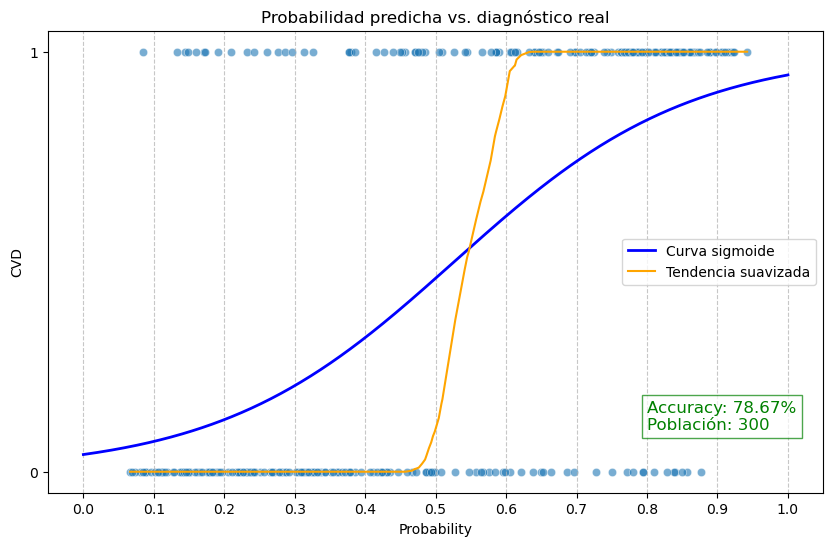

In [159]:
predict_dataset = CardioDataset(dataframe=test_df.iloc[:300])
predict_dataloader = DataLoader(predict_dataset, batch_size=1, shuffle= True)
predict(predict_dataloader, trained_model, 0.5)